In [3]:
from obspy.core import Stream, read
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import pandas as pd
import os 
import os.path

In [4]:
path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

dist_array = np.load(path_to_files + 'NA_evt-sta_dist_array_less500km_withdata_withrmssnrs_3COMP.npy')

# Array order:

# 0. Earthquake identifier
# 1. Earthquake origin time
# 2. Earthquake latitude
# 3. Earthquake longitude
# 4. Earthquake magnitude
# 5. Station name
# 6. Station latitude
# 7. Station longitude
# 8. Hypocentral distance (km)
# 9. RMS strain SNR

In [5]:
# Chosen events

# # Hypdist plots
# 2011-09-09_M6.4
# 2019-07-06_M7.1

# # SNR plots
# 2019-08-29_M6.3
# 2014-04-24_M6.5

In [6]:
# earthquakes

In [7]:
hyp_eqs = earthquakes.iloc[[21,27]]
snr_eqs = earthquakes.iloc[[10,20]]

hyp_eqs

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
21,2014-03-10T05:18:13.430Z,40.8286667,-125.1338333,16.441,6.8,mw,112,229,0.6568,0.15,...,2022-09-24T19:42:07.982Z,"77 km WNW of Indianola, California",earthquake,0.64,1.88,NaN,5,reviewed,nc,nc
27,2011-09-09T19:41:34.150Z,49.535,-126.893,22,6.4,mww,650,28.1,NaN,1.02,...,2022-08-09T02:54:49.608Z,"66 km SW of Vernon, Canada",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us


### Plot by event (rainbow for hypdist)

In [32]:
cmap = plt.get_cmap('magma', 500) 

for idx in range(len(earthquakes)):
    
    plot_p = True
    
    if idx == 21: 
        save_lett = 'a'
    elif idx == 27:
        save_lett = 'b'
    # elif idx == 11:
    #     pass
    else:
        continue
    
    fig = plt.figure(figsize = (10,6), dpi = 400, facecolor = 'white', num = 1, clear = True)
    ax = fig.add_subplot(111)
        
    ot = origin_times[idx]
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
    i = np.where(dist_array[:,0] == eq_id)[0]
    
    snrs = []
    
    for sta in stas:
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = float(dist_array[i][j][0][9])
            snrs.append(snr)
        
            # Peak strain data - only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/3comp_peak_post_p/' + str(eq_id) + '/' + str(sta) + '.mseed')
                
        except:
            continue # skips to next station
        
        if snr >= 2: # Can use to limit by SNR further

            pst_times = pst[0].times()
            pst_data = pst[0].data
            samp_rate = pst[0].stats.sampling_rate

            low_xlim_sec = 8
            high_xlim_sec = 30

            low_xlim_samp = int(low_xlim_sec * samp_rate)
            high_xlim_samp = int(high_xlim_sec * samp_rate)

            # Move the flat line at the beginning of each timeseries to the same level

            norm_data = np.copy(pst_data)
            norm_level = pst_data[0]
            norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

            ax.set_facecolor('lightgray')
            if plot_p:
                ax.axvline(x = 10, color = 'gray', linestyle = '--', alpha = 0.5, label = 'P-wave arrival')
                plot_p = False
            ax.plot(pst_times[low_xlim_samp:high_xlim_samp], norm_data[low_xlim_samp:high_xlim_samp], color = cmap(int_hypdist-1), label = sta)
            ax.set_yscale('log')
            ax.set_ylabel('Log of relative peak strain', fontsize = 15)
            ax.set_xlabel('Time (s)', fontsize = 15)
            ax.set_xlim(low_xlim_sec,high_xlim_sec)
            ax.tick_params(labelsize = 13)
        
        else:
            pass
        
    q = np.where(np.array(snrs) >= 2)[0]
            
    ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm = Normalize(0, 500), cmap = cmap), ax = ax)
    cbar.ax.tick_params(labelsize = 11)
    cbar.ax.set_ylabel(ylabel = 'Hypocentral distance (km)', fontsize = 13)
    ax.legend(loc = 'lower right', ncol = 3, fontsize = 10)

    # plt.show()    

    plt.savefig('/Users/sydneydybing/StrainProject/2024/Manuscript/Figures/Figure_5' + save_lett + '.png', format = 'PNG')
    plt.close();


## Colored by SNR

### Plot by event

0.43965738647
2554.68598641


(array([ 400.,    1.,    1.,    0.,    0.,    1.,    0.,    0.,    0.,    1.]),
 array([  4.39657386e-01,   2.55864290e+02,   5.11288923e+02,
          7.66713556e+02,   1.02213819e+03,   1.27756282e+03,
          1.53298745e+03,   1.78841209e+03,   2.04383672e+03,
          2.29926135e+03,   2.55468599e+03]),
 <BarContainer object of 10 artists>)

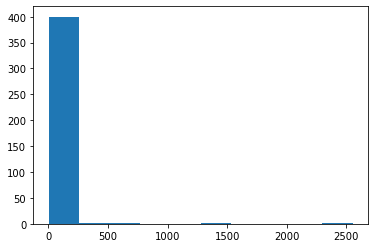

In [33]:
snrs = dist_array[:,9]
snrs_nonan = []

for snr in snrs:
#     print(snr)
    if snr != 'nan':
        snrs_nonan.append(float(snr))
        
print(min(snrs_nonan))
print(max(snrs_nonan))

plt.hist(snrs_nonan)

# max_snr = max(snrs_nonan)

# lim = 20

# m = np.where(np.array(snrs_nonan) <= lim)[0]
# print(len(m))

# plt.hist(np.array(snrs_nonan)[m], bins = 50)
# plt.xlim(0, lim);

In [35]:
# Change depending on SNR limits of plots

low_snr = 2
high_snr = 18

num_colors = high_snr - low_snr

cmap = plt.get_cmap('viridis', num_colors)
snr_color_mapping = np.arange(low_snr, high_snr+1, 1)
tolerance = 1e-10

In [37]:
for idx in range(len(earthquakes)):
    
    plot_p = True
    
    if idx == 11: 
        save_lett = 'c'
    elif idx == 20:
        save_lett = 'd'
    else:
        continue
    
    fig = plt.figure(figsize = (10,6), dpi = 400, facecolor = 'white', num = 1, clear = True)
    ax = fig.add_subplot(111)
        
    ot = origin_times[idx]
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
    
    eq_id = str(cut_ot) + '_M' + str(mags[idx])
        
    # Find rows that match this event in the array with the hypocentral distances
    
    i = np.where(dist_array[:,0] == eq_id)[0]
    
    snrs = []
    
    for sta in stas:
        
        try:
            
            # Find row that matches this station within the rows of the right event
            j = np.where(dist_array[i,5] == sta)[0]
            hypdist = float(dist_array[i][j][0][8])
            int_hypdist = int(hypdist)
            snr = int(float(dist_array[i][j][0][9]))
            snrs.append(snr)
        
            # Peak strain data - only has the ones with SNR > 2
            pst = read(path_to_files + 'strain_data/3comp_peak_post_p/' + str(eq_id) + '/' + str(sta) + '.mseed')
                
        except:
            continue # skips to next station
        
        if low_snr <= snr <= high_snr: # Can use to limit by SNR further

            snr_color_idx = np.where(np.abs(snr_color_mapping - snr) < tolerance)[0]
            color = cmap(snr_color_idx)
        
        else:
            color = 'red'
            
        pst_times = pst[0].times()
        pst_data = pst[0].data
        samp_rate = pst[0].stats.sampling_rate

        low_xlim_sec = 8
        high_xlim_sec = high_xlim_sec

        low_xlim_samp = int(low_xlim_sec * samp_rate)
        high_xlim_samp = int(high_xlim_sec * samp_rate)

        # Move the flat line at the beginning of each timeseries to the same level

        norm_data = np.copy(pst_data)
        norm_level = pst_data[0]
        norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

        ax.set_facecolor('lightgray')
        if plot_p:
            ax.axvline(x = 10, color = 'gray', linestyle = '--', alpha = 0.5, label = 'P-wave arrival')
            plot_p = False
        if snr >= high_snr:
            ax.plot(pst_times[low_xlim_samp:high_xlim_samp], norm_data[low_xlim_samp:high_xlim_samp], color = color, label = str(sta) + ', SNR = ' + str(snr))
        else:
            ax.plot(pst_times[low_xlim_samp:high_xlim_samp], norm_data[low_xlim_samp:high_xlim_samp], color = color, label = str(sta))
        ax.set_yscale('log')
        ax.set_ylabel('Log of relative peak strain', fontsize = 15)
        ax.set_xlabel('Time (s)', fontsize = 15)
        ax.set_xlim(low_xlim_sec,high_xlim_sec)
        ax.tick_params(labelsize = 13)

    q = np.where(np.array(snrs) >= 2)[0]
            
    # Plot after each earthquake
        
    # ax.set_title('Earthquake ' + str(cut_ot) + '_M' + str(mags[idx]), fontsize = 18)
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm = Normalize(low_snr, high_snr), cmap = cmap), ax = ax)
    cbar.ax.tick_params(labelsize = 11)
    cbar.ax.set_ylabel(ylabel = 'SNR', fontsize = 13)
    ax.legend(loc = 'lower right', ncol = 3, fontsize = 10)

    # plt.show()

    plt.savefig('/Users/sydneydybing/StrainProject/2024/Manuscript/Figures/Figure_5' + save_lett + '.png', format = 'PNG')
    plt.close();
